<a href="https://colab.research.google.com/github/jlee1998/Advanced-Project-in-Mathematics/blob/main/GRU_ODE_Bayes_Explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Introduction

This is a condensed version of the GRU-ODE-Bayes method by De Brouwer, Simm, Moreau and Arany (2019) tested on the double Ornstein-Uhlenbeck process. The page numbers refer to the original paper https://arxiv.org/pdf/1905.12374.pdf

The source code is here: https://github.com/edebrouwer/gru_ode_bayes

I have removed lines of code that are irrelevant to the implementation and added annotations and extra explanations as needed. Remember to press Ctrl+M+L to show the line numbers in the code!

# 1. Data Preprocessing

In [1]:
pip install git+https://github.com/rtqichen/torchdiffeq/

  Cloning https://github.com/rtqichen/torchdiffeq/ to /tmp/pip-req-build-m51mcte_
  Running command git clone -q https://github.com/rtqichen/torchdiffeq/ /tmp/pip-req-build-m51mcte_
  Created wheel for torchdiffeq: filename=torchdiffeq-0.2.1-cp37-none-any.whl size=31195 sha256=b3ec063af4110fb7d9826be96b915e9c71241906fa7c37c9e7bac873f2dd616b
  Stored in directory: /tmp/pip-ephem-wheel-cache-7t5junni/wheels/19/a0/ee/5623ea3a96376e4f2d6f949fd04d6287ff8f8b0c30fafbdc0b
Successfully built torchdiffeq


In [2]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from scipy import special

class ODE_Dataset(Dataset):
    """
    Dataset class for ODE type of data. With 2 values.
    Can be fed with either a csv file containg the dataframe or directly with a panda dataframe.
    One can further provide samples idx that will be used (for training / validation split purposes.)
    """
    def __init__(self, panda_df, idx=None, validation = False, val_options = None):
        """
        Args:
            panda_df   alternatively use pandas df instead of CSV file
            root_dir   directory of the CSV file
            t_mult     multiplier for time values (1.0 default)
            val_options  dictionnary with validation dataset options.
                                    T_val : Time after which observations are considered as test samples
                                    max_val_samples : maximum number of test observations per trajectory.

        """
        self.validation = validation

        if panda_df is not None:
            self.df = panda_df
#first column of the dataframe is an index column: all observations from the same simulation have the same ID number
       

#Create Dummy covariates and labels if they are not fed.

#Count the number (num_unique) of distinct observations and create a zero matrix of dimension num_unique
        num_unique = np.zeros(self.df["ID"].nunique())
#Return the sorted unique elements of df[“ID”] and stick the column Cov to create a new dataframe cov_df
        self.cov_df = pd.DataFrame({"ID":self.df["ID"].unique(),"Cov": num_unique})
#Do the same for label_df
        self.label_df = pd.DataFrame({"ID":self.df["ID"].unique(),"label": num_unique})

        #If validation : consider only the data with a least one observation before T_val and one observation after:
        self.store_last = False
        if self.validation:
#create a dataframe of observations that take place before time=val_options
            df_beforeIdx = self.df.loc[self.df["Time"]<=val_options["T_val"],"ID"].unique()
            if val_options.get("T_val_from"): #Validation samples only after some time.
#create a dataframe df_afterIdx containing unique validation samples – these can only occur after time=T_val 
                df_afterIdx  = self.df.loc[self.df["Time"]>=val_options["T_val_from"],"ID"].unique()
                self.store_last = True #Dataset get will return a flag for the collate to compute the last sample before T_val
            else:
                df_afterIdx  = self.df.loc[self.df["Time"]>val_options["T_val"],"ID"].unique()
 #valid_idx= samples that occur at time=T_val
            valid_idx = np.intersect1d(df_beforeIdx,df_afterIdx)
            self.df = self.df.loc[self.df["ID"].isin(valid_idx)]
#creates a Boolean series which is ‘True’ when ID=valid_idx, ‘False’ otherwise
            self.label_df = self.label_df.loc[self.label_df["ID"].isin(valid_idx)]
            self.cov_df   = self.cov_df.loc[self.cov_df["ID"].isin(valid_idx)]

        if idx is not None:
            self.df = self.df.loc[self.df["ID"].isin(idx)].copy()
            map_dict= dict(zip(self.df["ID"].unique(),np.arange(self.df["ID"].nunique())))
            self.df["ID"] = self.df["ID"].map(map_dict) # Reset the ID index.

            self.cov_df = self.cov_df.loc[self.cov_df["ID"].isin(idx)].copy()
            self.cov_df["ID"] = self.cov_df["ID"].map(map_dict) # Reset the ID index.

            self.label_df = self.label_df.loc[self.label_df["ID"].isin(idx)].copy()
            self.label_df["ID"] = self.label_df["ID"].map(map_dict) # Reset the ID index.

        assert self.cov_df.shape[0]==self.df["ID"].nunique()

        self.variable_num = sum([c.startswith("Value") for c in self.df.columns]) #number of variables in the dataset
        self.cov_dim = self.cov_df.shape[1]-1

        self.cov_df = self.cov_df.astype(np.float32)
        self.cov_df.set_index("ID", inplace=True)

        self.label_df.set_index("ID",inplace=True)

        self.df = self.df.astype(np.float32)

        if self.validation:
            assert val_options is not None, "Validation set options should be fed"
            self.df_before = self.df.loc[self.df["Time"]<=val_options["T_val"]].copy()
            if val_options.get("T_val_from"): #Validation samples (contained in df_after ) only after some time.
                self.df_after  = self.df.loc[self.df["Time"]>=val_options["T_val_from"]].sort_values("Time").copy()
            else:
                self.df_after  = self.df.loc[self.df["Time"]>val_options["T_val"]].sort_values("Time").copy()

            if val_options.get("T_closest") is not None:
                df_after_temp = self.df_after.copy()
                df_after_temp["Time_from_target"] = (df_after_temp["Time"]-val_options["T_closest"]).abs()
                df_after_temp.sort_values(by=["Time_from_target","Value_0"], inplace = True,ascending=True)
                df_after_temp.drop_duplicates(subset=["ID"],keep="first",inplace = True)
                self.df_after = df_after_temp.drop(columns = ["Time_from_target"])
            else:
                self.df_after  = self.df_after.groupby("ID").head(val_options["max_val_samples"]).copy()

            self.df = self.df_before #We remove observations after T_val

            self.df_after.ID = self.df_after.ID.astype(np.int)
            self.df_after.sort_values("Time", inplace=True)
        else:
            self.df_after = None

        self.length     = self.df["ID"].nunique()
        self.df.ID      = self.df.ID.astype(np.int)
        self.df.set_index("ID", inplace=True)

        self.df.sort_values("Time", inplace=True)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        subset = self.df.loc[idx]
        if len(subset.shape)==1: #Don't ask me anything about this.
            subset = self.df.loc[[idx]]

        covs = self.cov_df.loc[idx].values
        tag  = self.label_df.loc[idx].astype(np.float32).values
        if self.validation :
            val_samples = self.df_after.loc[self.df_after["ID"]==idx]
        else:
            val_samples = None
        ## returning also idx to allow empty samples
        return {"idx":idx, "y": tag, "path": subset, "cov": covs , "val_samples":val_samples, "store_last":self.store_last}


def custom_collate_fn(batch):
#One-dimensional ndarray with axis/index labels (including time series)
    idx2batch = pd.Series(np.arange(len(batch)), index = [b["idx"] for b in batch])

    pat_idx   = [b["idx"] for b in batch]
    df        = pd.concat([b["path"] for b in batch],axis=0)
    df.sort_values(by=["Time"], inplace=True)
#turn everything to torch tensors
    df_cov    = torch.Tensor([b["cov"] for b in batch])

    labels  = torch.tensor([b["y"] for b in batch])

    batch_ids     = idx2batch[df.index.values].values

    ## calculating number of events at every time
    times, counts = np.unique(df.Time.values, return_counts=True)
    time_ptr      = np.concatenate([[0], np.cumsum(counts)])

    ## tensors for the data in the batch

    value_cols = [c.startswith("Value") for c in df.columns]
    mask_cols  = [c.startswith("Mask") for c in df.columns]

    if batch[0]['val_samples'] is not None:
        df_after = pd.concat(b["val_samples"] for b in batch)
        df_after.sort_values(by=["ID","Time"], inplace=True)
        value_cols_val = [c.startswith("Value") for c in df_after.columns]
        mask_cols_val  = [c.startswith("Mask") for c in df_after.columns]

        X_val = torch.tensor(df_after.iloc[:,value_cols_val].values)
        M_val = torch.tensor(df_after.iloc[:,mask_cols_val].values)
        times_val = df_after["Time"].values
        index_val = idx2batch[df_after["ID"].values].values

        # Last observation before the T_val cut_off. THIS IS LIKELY TO GIVE ERRORS IF THE NUMBER OF VALIDATION SAMPLES IS HIGHER THAN 2. CHECK THIS.
        if batch[0]["store_last"]:
            df_last = df[~df.index.duplicated(keep="last")].copy()
            index_last = idx2batch[df_last.index.values].values
        
            perm_last = sort_array_on_other(index_val,index_last)
            tens_last = torch.tensor(df_last.iloc[:,value_cols].values[perm_last,:])
            index_last = index_last[perm_last]
        else:
            index_last = 0
            tens_last = 0
    else:
        X_val = None
        M_val = None
        times_val = None
        index_val = None
        tens_last = None
        index_last = None

    res = {}
    res["pat_idx"]  = pat_idx
    res["times"]    = times
    res["time_ptr"] = time_ptr
    res["X"]        = torch.tensor(df.iloc[:, value_cols].values)
    res["M"]        = torch.tensor(df.iloc[:, mask_cols].values)
    res["obs_idx"]  = torch.tensor(batch_ids)
    res["y"]        = labels
    res["cov"]      = df_cov
    res["X_val"]    = X_val
    res["M_val"]    = M_val
    res["times_val"]= times_val
    res["index_val"]= index_val
    res["X_last"]   = tens_last
    res["obs_idx_last"]= index_last

    return res

def seq_collate_fn(batch):
    """
    Returns several tensors. Tensor of lengths should not be sent to CUDA.
    """
    idx2batch  = pd.Series(np.arange(len(batch)), index = [b["idx"] for b in batch])
    df         = pd.concat(b["path"] for b in batch)
    value_cols = [c.startswith("Value") for c in df.columns]
    mask_cols  = [c.startswith("Mask") for c in df.columns]

    ## converting mask to int
    df.iloc[:, mask_cols] = df.iloc[:, mask_cols].astype(np.bool)
    df["num_obs"]         = -df.iloc[:,mask_cols].sum(1)
    df.sort_values(by=["Time", "num_obs"], inplace=True)

    ## num_obs is not a value/mask column
    value_cols.append(False)
    mask_cols.append(False)

    cov = torch.Tensor([b["cov"] for b in batch])

    batch_ids = idx2batch[df.index.values].values

    ## calculating number of events at every time
    times, counts = np.unique(df.Time.values, return_counts=True)
    time_ptr      = np.concatenate([[0], np.cumsum(counts)])
    assert df.shape[0] == time_ptr[-1]

    ## tensors for the data in the batch
    X = df.iloc[:, value_cols].values
    M = df.iloc[:, mask_cols].values

    ## selecting only observed X and splitting
    lengths = (-df.num_obs.values).tolist()
    Xsplit  = torch.split(torch.from_numpy(X[M]), lengths)
    Fsplit  = torch.split(torch.from_numpy(np.where(M)[1]), lengths)

    Xpadded = torch.nn.utils.rnn.pad_sequence(Xsplit, batch_first=True)
    Fpadded = torch.nn.utils.rnn.pad_sequence(Fsplit, batch_first=True)

    if batch[0]['val_samples'] is not None:
        df_after = pd.concat(b["val_samples"] for b in batch)
        df_after.sort_values(by=["ID","Time"], inplace=True)
        value_cols_val = [c.startswith("Value") for c in df_after.columns]
        mask_cols_val  = [c.startswith("Mask") for c in df_after.columns]
        X_val = torch.tensor(df_after.iloc[:,value_cols_val].values)
        M_val = torch.tensor(df_after.iloc[:,mask_cols_val].values)
        times_val = df_after["Time"].values
        index_val = idx2batch[df_after["ID"].values].values
    else:
        X_val = None
        M_val = None
        times_val = None
        index_val = None

    res = {}
    res["times"]    = times
    res["time_ptr"] = time_ptr
    res["Xpadded"]  = Xpadded
    res["Fpadded"]  = Fpadded
    res["X"]        = torch.from_numpy(X)
    res["M"]        = torch.from_numpy(M.astype(np.float32))
    res["lengths"]  = torch.LongTensor(lengths)
    res["obs_idx"]  = torch.tensor(batch_ids)
    res["y"]        = torch.tensor([b["y"] for b in batch])
    res["cov"]      = cov

    res["X_val"]    = X_val
    res["M_val"]    = M_val
    res["times_val"]=times_val
    res["index_val"]=index_val

    return res

def extract_from_path(t_vec, p_vec, eval_times, path_idx_eval):
    '''
    Takes :
    t_vec : numpy vector of absolute times length [T]. Should be ordered.
    p_vec : numpy array of means and logvars of a trajectory at times t_vec. [T x batch_size x (2xfeatures)]
    eval_times : numpy vector of absolute times at which we want to retrieve p_vec. [L]
    path_idx_eval : index of trajectory that we want to retrieve. Should be same length of eval_times. [L]
    Returns :
    Array of dimensions [L,(2xfeatures)] of means and logvar of the required eval times and trajectories
    '''
    #Remove the evaluation after the updates. Only takes the prediction before the Bayesian update. 
    t_vec, unique_index = np.unique(t_vec,return_index=True)
    p_vec = p_vec[unique_index,:,:]

    present_mask = np.isin(eval_times, t_vec)
    eval_times[~present_mask] = map_to_closest(eval_times[~present_mask],t_vec)

    mapping = dict(zip(t_vec,np.arange(t_vec.shape[0])))

    time_idx = np.vectorize(mapping.get)(eval_times)

    return(p_vec[time_idx,path_idx_eval,:])

def map_to_closest(input,reference):
    output = np.zeros_like(input)
    for idx, element in enumerate(input):
        closest_idx=(np.abs(reference-element)).argmin()
        output[idx]=reference[closest_idx]
    return(output)
#gives option to change learning rate as you train if you want
def adjust_learning_rate(optimizer, epoch, init_lr):
    if epoch > 20:
        for param_group in optimizer.param_groups:
            param_group["lr"] = init_lr/3
#gives correlation between true and predicted process            
def compute_corr(X_true, X_hat, Mask):
    means_true = X_true.sum(0)/Mask.sum(0)
    means_hat  = X_hat.sum(0)/Mask.sum(0)
    corr_num = ((X_true-means_true)*(X_hat-means_hat)*Mask).sum(0)
    corr_denum1 = ((X_true-means_true).pow(2)*Mask).sum(0).sqrt()
    corr_denum2 = ((X_hat-means_hat).pow(2)*Mask).sum(0).sqrt()
    return corr_num/(corr_denum1*corr_denum2)

def sort_array_on_other(x1,x2):
    """
    This function returns the permutation y needed to transform x2 in x1 s.t. x2[y]=x1
    """

    temp_dict = dict(zip(x1,np.arange(len(x1))))
    index = np.vectorize(temp_dict.get)(x2)
    perm = np.argsort(index)

    assert((x2[perm]==x1).all())

    return(perm)

def log_lik_gaussian(x,mu,logvar):
    return np.log(np.sqrt(2*np.pi)) + (logvar/2) + ((x-mu).pow(2)/(2*logvar.exp()))

def tail_fun_gaussian(x,mu,logvar):
    """
    Returns the probability that the given distribution is HIGHER than x.
    """
    return 0.5-0.5*special.erf((x-mu)/((0.5*logvar).exp()*np.sqrt(2)))

import torch
import math
import numpy as np
from torchdiffeq import odeint

from torch.nn.utils.rnn import pack_padded_sequence


# 2. GRU-ODE-Bayes Algorithm

The module FullGRODECell performs part of the GRU-ODE algorithm between observations. Remember that the ODE we solve (page 3) is given by:

$    \frac{dh(t)}{dt}= (1-z(t))\odot (u(t) - h(t))$

which is a continuous time version of the difference equation

$    h_t=z_t \odot h_{t-1}+(1-z_t) \odot g_t$

$    r_t=\sigma(W_r x_t+U_r h_{t-1}) \in [0,1]$

$    z_t=\sigma(W_z x_t+U_z h_{t-1}) \in [0,1]$

$    g_t=\tanh(W_h x_t+U_h (r_t \odot h_{t-1}))\in [-1,1]
$

Given our initial condition $h(0)=0$, we simply use the Euler method

$h_{n+1}=h_n+f_n \Delta t$
 to describe the forward evolution of $h(t)$ in time. FullGRUODECell gives us our $f_n$ (or 'dh' in the code below)

Note that lin_x is a linear map that transforms the input $x_t$ to the arrays $x_r=W_r x_t+b_r$, $x_z=W_z x_t+ b_z$ and $x_h=W_h x_t+ b_h$




In [7]:
class FullGRUODECell(torch.nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        """
        For p(t) modelling input_size should be 2x the x size.
        """
        super().__init__()


        self.lin_x = torch.nn.Linear(input_size, hidden_size * 3, bias=bias)
#linear maps defined by a matrix with dimensions (hidden_size,hidden_size)
        self.lin_hh = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.lin_hz = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.lin_hr = torch.nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, h):
        """
        Executes one step with GRU-ODE for all h.
        The step size is given by delta_t.

        Args:
            x        input values
            h        hidden state (current)
            delta_t  time step

        Returns:
            Updated h
        """
#define transformations xr=W_r x_t+b_r, xz=W_z x_t +b_z ,xh=W_h x_t+b_h
        xr, xz, xh = torch.chunk(self.lin_x(x), 3, dim=1)
        r = torch.sigmoid(xr + self.lin_hr(h))
        z = torch.sigmoid(xz + self.lin_hz(h))
        u = torch.tanh(xh + self.lin_hh(r * h))

        dh = (1 - z) * (u - h)
        return dh

GRUObservationCellLogvar performs GRU-Bayes, described in page 4 and page 14 (Appendix D). In other words, it does the following steps to update $h(t)$ at the observation times:

1. For each dimension of the stochastic process, compute $\theta_d$, a vector containing the mean and variance (or log-variance) of $Y(t)$ (line 23).

2. Then create the concatenation $q_d=[\theta_d,y[k]_d,\frac{y[k]_d-\mu_d}{\sigma_d}]$, (line 38, "gru_input") where $y[k]_d$ ("X_obs") is the observation for dimension $d$ and $\frac{y[k]_d-\mu_d}{\sigma_d}$ is the corresponding normalized error term (line 28). Line 26 shows us how to recover the standard deviation $\sigma$ from the log-variance.

3. Next, to account for missingness across observations, we calculate $f_d=ReLU(W_d q_d)m_d$ (line 40), where $W_d$ is a weight matrix (w_prep, with bias term bias_prep defined in lines 13-14 in the code) and $m_d$ is a mask matrix which replaces all entries which are not observed.

4. $f_{prep}(y[k],m[k],h(t_)$ (line 46) is what we plug in to the discrete GRU algorithm (page 3) (line 50) to give us $h_+$



In [ ]:
class GRUObservationCellLogvar(torch.nn.Module):
    """Implements discrete update based on the received observations."""#i.e. performs GRU-Bayes

    def __init__(self, input_size, hidden_size, prep_hidden, bias=True):
        super().__init__()
#this function performs a discrete GRU algorithm
        self.gru_d     = torch.nn.GRUCell(prep_hidden * input_size, hidden_size, bias=bias)
        self.gru_debug = torch.nn.GRUCell(prep_hidden * input_size, hidden_size, bias=bias)

        ## prep layer and its initialization
        std            = math.sqrt(2.0 / (4 + prep_hidden))
#initialize (random) preprocessing weight matrix 
        self.w_prep    = torch.nn.Parameter(std * torch.randn(input_size, 4, prep_hidden))
        self.bias_prep = torch.nn.Parameter(0.1 + torch.zeros(input_size, prep_hidden))

        self.input_size  = input_size
#number of hidden layers
        self.prep_hidden = prep_hidden

    def forward(self, h, p, X_obs, M_obs, i_obs):
        ## only updating rows that have observations
        p_obs        = p[i_obs]
#obtain mean and log variance
        mean, logvar = torch.chunk(p_obs, 2, dim=1)
#calculate standard deviation from the log variance
        sigma        = torch.exp(0.5 * logvar)
#calculate normalized error
        error        = (X_obs - mean) / sigma

        ## log normal loss, over all observations
        log_lik_c    = np.log(np.sqrt(2*np.pi))
        losses       = 0.5 * ((torch.pow(error, 2) + logvar + 2*log_lik_c) * M_obs)
        if losses.sum()!=losses.sum():
            import ipdb; ipdb.set_trace()

        ## TODO: try removing X_obs (they are included in error)
#concatenate observed values, mean, log variance and normalized errors
        gru_input    = torch.stack([X_obs, mean, logvar, error], dim=2).unsqueeze(2)
#multiply  by weight matrix w_prep
        gru_input    = torch.matmul(gru_input, self.w_prep).squeeze(2) + self.bias_prep
#push it through a relu function
        gru_input.relu_()
        ## gru_input is (sample x feature x prep_hidden)
        gru_input    = gru_input.permute(2, 0, 1)
#multiply masks to account for missingness across features
        gru_input    = (gru_input * M_obs).permute(1, 2, 0).contiguous().view(-1, self.prep_hidden * self.input_size)

        temp = h.clone()
#apply discrete GRU algorithm with h- and f=gru_prep
        temp[i_obs] = self.gru_d(gru_input, h[i_obs])
        h = temp

        return h, losses

init_weights simply initializes the weight matrices.

In [ ]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.05)


p_model and classification_model are maps that do the following to the input:

1.	Apply a linear transformation
2.	Then apply ReLU function
3.	Then apply dropout (optional)
4.	Then apply another linear transformation

gru_c is the function that solves the ODE above with the Euler method with the output from FullGRUODECell.

forward is a function that takes a tensor of inputs and tells us to perform GRU-ODE (described by FullGRUODECell) between observations and GRU-Bayes (given by GRUObservationCellLogvar) when we hit an observation. X_obs, M_obs and i_obs are the inputs, masks and indices at the observation times. loss_1 and loss_2 are the $Loss_{pre}$ and $Loss_{post}$ described in page 5.

In [ ]:
class NNFOwithBayesianJumps(torch.nn.Module):
    ## Neural Negative Feedback ODE with Bayesian jumps
    def __init__(self, input_size, hidden_size, p_hidden, prep_hidden, bias=True, cov_size=1, cov_hidden=1, classification_hidden=1, mixing=1, dropout_rate=0, solver="euler", impute = True, **options):
        """
        The smoother variable computes the classification loss as a weighted average of the projection of the latents at each observation.
        impute feeds the parameters of the distribution to GRU-ODE at each step.
        """

        super().__init__()

        self.impute = impute

        self.p_model = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, p_hidden, bias=bias),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.Linear(p_hidden, 2 * input_size, bias=bias),
        )
        self.classification_model = torch.nn.Sequential(
            torch.nn.Linear(hidden_size,classification_hidden,bias=bias),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.Linear(classification_hidden,1,bias=bias)
        )
#performs GRU-ODE
        self.gru_c   = FullGRUODECell(2 * input_size, hidden_size, bias=bias)               

#performs GRU-Bayes
        self.gru_obs = GRUObservationCellLogvar(input_size, hidden_size, prep_hidden, bias=bias)

        self.covariates_map = torch.nn.Sequential(
            torch.nn.Linear(cov_size, cov_hidden, bias=bias),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.Linear(cov_hidden, hidden_size, bias=bias),
            torch.nn.Tanh()
        )
#use Euler method to solve ODE
        #self.solver     = “euler”
        self.store_hist = options.pop("store_hist",False)
        self.input_size = input_size
        #self.logvar     = logvar
        self.mixing     = mixing #mixing hyperparameter for loss_1 and loss_2 aggregation.

        self.apply(init_weights)

    def ode_step(self, h, p, delta_t, current_time):
        """Executes a single ODE step."""
        eval_times = torch.tensor([0],device = h.device, dtype = torch.float64)
        eval_ps = torch.tensor([0],device = h.device, dtype = torch.float32)
        if self.impute is False:
            p = torch.zeros_like(p)
            

        h = h + delta_t * self.gru_c(p, h)
        p = self.p_model(h)


        current_time += delta_t
        return h,p,current_time, eval_times, eval_ps

        raise ValueError(f"Unknown solver '{self.solver}'.")

    def forward(self, times, time_ptr, X, M, obs_idx, delta_t, T, cov,
                return_path=False, smoother = False, class_criterion = None, labels=None):
        """
        Args:
            times      np vector of observation times
            time_ptr   start indices of data for a given time
            X          data tensor
            M          mask tensor (1.0 if observed, 0.0 if unobserved)
            obs_idx    observed patients of each datapoint (indexed within the current minibatch)
            delta_t    time step for Euler
            T          total time
            cov        static covariates for learning the first h0
            return_path   whether to return the path of h

        Returns:
            h          hidden state at final time (T)
            loss       loss of the Gaussian observations
        """

        h = self.covariates_map(cov)

        p            = self.p_model(h)
        current_time = 0.0
        counter      = 0

        loss_1 = 0 #Pre-jump loss
        loss_2 = 0 #Post-jump loss (KL between p_updated and the actual sample)

        if return_path:
            path_t = [0]
            path_p = [p]
            path_h = [h]

        if smoother:
            class_loss_vec = torch.zeros(cov.shape[0],device = h.device)
            num_evals_vec  = torch.zeros(cov.shape[0],device = h.device)
            class_criterion = class_criterion
            assert class_criterion is not None

        assert len(times) + 1 == len(time_ptr)
        assert (len(times) == 0) or (times[-1] <= T)

        eval_times_total = torch.tensor([],dtype = torch.float64, device = h.device)
        eval_vals_total  = torch.tensor([],dtype = torch.float32, device = h.device)

        for i, obs_time in enumerate(times):
            ## Propagation of the ODE until next observation
            while current_time < (obs_time-0.001*delta_t): #0.0001 delta_t used for numerical consistency.
#solve ODE
                 
                h, p, current_time, eval_times, eval_ps = self.ode_step(h, p, delta_t, current_time)
                eval_times_total = torch.cat((eval_times_total, eval_times))
                eval_vals_total  = torch.cat((eval_vals_total, eval_ps))

                #Storing the predictions.
            if return_path:
                    path_t.append(current_time)
                    path_p.append(p)
                    path_h.append(h)

            ## Reached an observation
            start = time_ptr[i]
            end   = time_ptr[i+1]

            X_obs = X[start:end]
            M_obs = M[start:end]
            i_obs = obs_idx[start:end]

            ## Using GRUObservationCell to update h (i.e. perform GRU-Bayes_. Also updating p and loss
            h, losses = self.gru_obs(h, p, X_obs, M_obs, i_obs)
           
            if smoother:
                class_loss_vec[i_obs] += class_criterion(self.classification_model(h[i_obs]),labels[i_obs]).squeeze(1)
                num_evals_vec[i_obs] +=1
            if losses.sum()!=losses.sum():
                import ipdb;ipdb.set_trace()
            loss_1    = loss_1+ losses.sum()
            p         = self.p_model(h)
#compute KL divergence between true and predicted posterior distributions
            loss_2 = loss_2 + compute_KL_loss(p_obs = p[i_obs], X_obs = X_obs, M_obs = M_obs)

            if return_path:
                path_t.append(obs_time)
                path_p.append(p)
                path_h.append(h)

        ## after every observation has been processed, propagating until T
            h, p, current_time,eval_times, eval_ps = self.ode_step(h, p, delta_t, current_time)
            eval_times_total = torch.cat((eval_times_total,eval_times))
            eval_vals_total  = torch.cat((eval_vals_total, eval_ps))
            #counter += 1
            #current_time = counter * delta_t
            
            #Storing the predictions
            if return_path:
                path_t.append(current_time)
                path_p.append(p)
                path_h.append(h)
#total loss=loss_pre+loss_post
        loss = loss_1 + self.mixing * loss_2

        if smoother:
            class_loss_vec += class_criterion(self.classification_model(h),labels).squeeze(1)
            class_loss_vec /= num_evals_vec
        
        class_pred = self.classification_model(h)
       
        if return_path:
            if smoother:
                return h, loss, class_pred, np.array(path_t), torch.stack(path_p), torch.stack(path_h), class_loss_vec
            else:
                return h, loss, class_pred, np.array(path_t), torch.stack(path_p), torch.stack(path_h), eval_times_total, eval_vals_total
        else:
            if smoother:
                return h, loss, class_pred, class_loss_vec
            else:
                return h, loss, class_pred, loss_1

The functions below computes the Kullback-Leibler divergence between the true posterior distribution and the predicted posterior distribution (after the GRU-Bayes update) of the process.

In [ ]:
def compute_KL_loss(p_obs, X_obs, M_obs, obs_noise_std=1e-2, logvar=True):
    obs_noise_std = torch.tensor(obs_noise_std)
    if logvar:
        mean, var = torch.chunk(p_obs, 2, dim=1)
        std = torch.exp(0.5*var)
    else:
        mean, var = torch.chunk(p_obs, 2, dim=1)
        ## making var non-negative and also non-zero (by adding a small value)
        std       = torch.pow(torch.abs(var) + 1e-5,0.5)
        
    return (gaussian_KL(mu_1 = mean, mu_2 = X_obs, sigma_1 = std, sigma_2 = obs_noise_std)*M_obs).sum()

In [ ]:
def gaussian_KL(mu_1, mu_2, sigma_1, sigma_2):
    return(torch.log(sigma_2) - torch.log(sigma_1) + (torch.pow(sigma_1,2)+torch.pow((mu_1 - mu_2),2)) / (2*sigma_2**2) - 0.5)

# 3. OU Dataset Generation

The function OU gives a simulation of the two dimensional highly correlated Ornstein-Uhlenbeck process (page . N_t is the number of time points we use, dt is the gap between time points.

The drift term $\mu$ is defined as follows:

$\mu=\frac{1}{12}\sigma_r U+\mu_r$

where $U$ is a 2D uniformly distributed random variable with values between $[-0.5,0.5]$


 random_theta is an option that allows us to create a random value for the parameter $\theta$ each time we run the function.

OU_sample creates a dataframe of N simulations (in our examples, 10000) of the OU process with an option Full that can be switch on/off depending on whether we want a dataset with missing observations. If Full=False, then for 40% of the times, we only observe dimension 1; for 40% of the time, we only observe dimension 2; for the remaining 20% of the time points, we observe both dimensions at once.

The part of the code below if __name__=="__main__": gives us our dataset we use for the training and produces 10 scatter plots of sparsely observed points from an OU process.


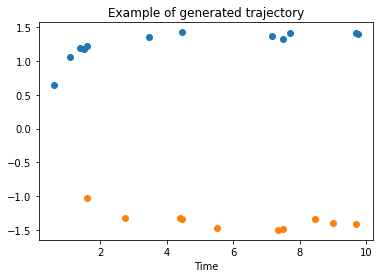

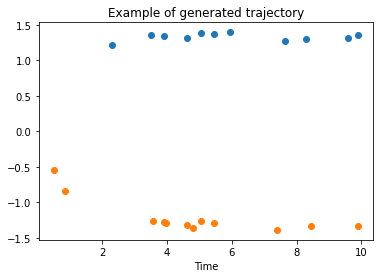

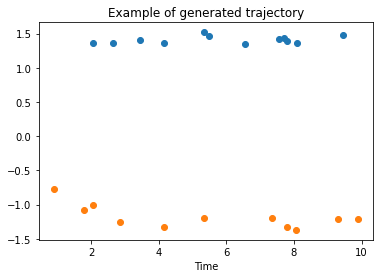

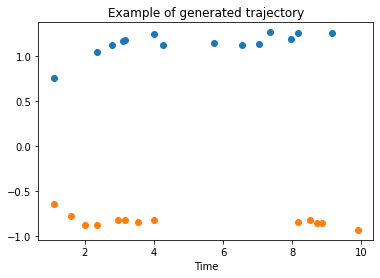

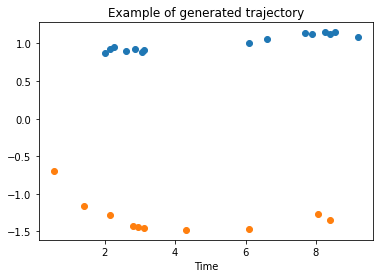

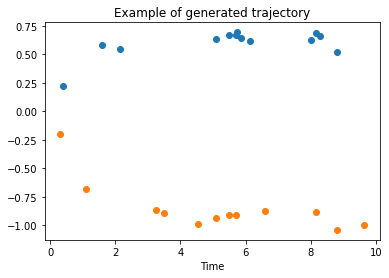

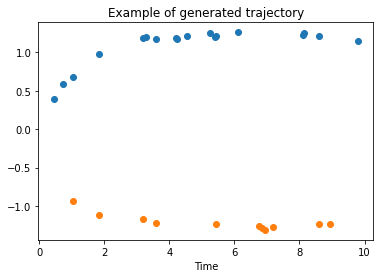

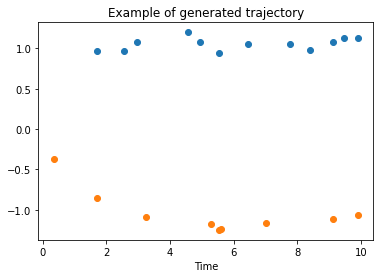

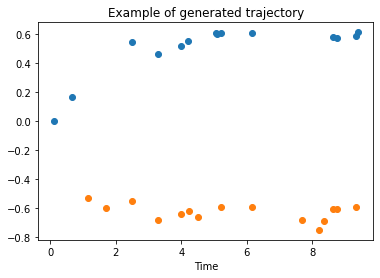

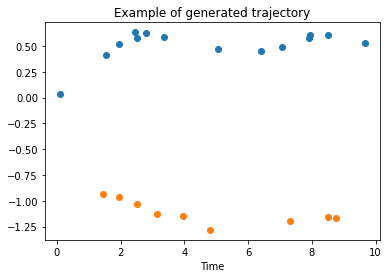

In [4]:
import numpy as np
import pandas as pd
import argparse
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def OU(T, dt, r_mu, r_std, theta=10, N_sims=1, sigma=0.1, rho=-0.99, random_theta=False):
    N_t  = int(T//dt)
    mu   = np.sqrt(12)*r_std*np.random.uniform(low=-0.5,high=0.5,size=(N_sims,2)) + r_mu #uniform distribution
    if random_theta:
        theta = np.random.uniform(low=0.1,high=1.5,size=(N_sims,1))
    sims = np.zeros((N_sims, N_t, 2))
#create a 2D covariance matrix for the Brownian motion 
    cov  = dt * np.array([[sigma**2,       sigma**2 * rho],[sigma**2 * rho, sigma**2]])
#create vector of 2D correlated Brownian motions
    dW   = np.random.multivariate_normal([0, 0], cov, size=(N_sims, N_t))
#solve the OU SDE between [0,N_t] using Euler-Maruyama method
    for i in range(1,N_t):
        sims[:, i] = sims[:,(i-1)] - theta * (sims[:,(i-1)] - mu)*dt + dW[:,i]
    return sims.astype(np.float32)

def OU_sample(T,dt,theta,N,sigma,r_mu,r_std,rho,sample_rate,dual_sample_rate,max_lag, random_theta, full=False,seed=432):
    '''
    Samples from N 2 dimensional OU process with opposite means.
    The sample rate should be expressed in samples per unit of time. (on average there will be sample_rate*T sample per series)
    The dual_sample rate gives the proportion of samples wich are jointly sampled (for both dimensions)
    We generate dummy covariates (all 0)
    '''
    np.random.seed(seed)
#create one OU sample
    y_vec = OU(T+max_lag, dt=dt, r_mu=r_mu, r_std=r_std, theta=theta, rho=rho, N_sims=N, random_theta=random_theta)
#N_t=number of time points in the (full)time series
    N_t = int(T//dt)
    p_single=1-dual_sample_rate
    p_both=dual_sample_rate
#create columns of dataset

    col=["ID","Time","Value_1","Value_2","Mask_1","Mask_2","Cov"]
    df = pd.DataFrame(columns=col)
#N= number of simulations of time series
    for i in range(N):
        variability_num_samples=0.2 #variability in number of samples for each trajectory.
        #Make sure that there is enough possibilities for sampling the number of observations.
        if variability_num_samples*2*sample_rate*T<1:
            num_samples=int(sample_rate*T)
        else:
            num_samples=np.random.randint(sample_rate*T*(1-variability_num_samples),sample_rate*T*(1+variability_num_samples)) #number of sample varies around the mean with 20% variability

        index_max_lag = int(max_lag//dt)
        lag = np.random.randint(low=0,high=index_max_lag+1)
#if full, then we use the full dataset
        if full:
            sample_times = np.arange(N_t)
            sample_type = (np.ones(N_t)*2).astype(np.int)
            num_samples=N_t
        else:
            sample_times=np.random.choice(N_t,num_samples,replace=False)
            sample_type=np.random.choice(3,num_samples,replace=True,p=[p_single/2,p_single/2,p_both])
        samples=y_vec[i,sample_times+lag,:]

        #non observed samples are set to 0
        samples[sample_type==0,1] = 0
        samples[sample_type==1,0] = 0

        #Observed samples have mask 1, others have 0.
        mask=np.ones((num_samples,2))
        mask[sample_type==0,1]=0
        mask[sample_type==1,0]=0
#covs= column of covariates (just zero vector)

        covs=np.zeros((num_samples,1))
        individual_data=pd.DataFrame(np.concatenate((i*np.ones((num_samples,1)),dt*np.expand_dims(sample_times,1),samples,mask,covs),1),columns=col)

#append new simulation to the bottom of the dataframe
        df=df.append(individual_data)
    df.reset_index(drop=True,inplace=True)
    return(df)


#create a (reduced) dataset of 10000 simulations i.e. we only have 15-20 points from each trajectory
if __name__=="__main__":
    parser = argparse.ArgumentParser(description="Generating 2D OU datasets.")
#correlation of Brownian motion terms is 0.99
    parser.add_argument('--rho', type=float, help="Correlation between the two variables.", default=0.99)
    parser.add_argument('--prefix', type=str, help="Prefix for generated data", default="double_OU")
    parser.add_argument('--random_r',action="store_true", help="Generates random targets (r) from uniform distribution with mean 1 (-1) and std = 0.5",default = True)
    parser.add_argument('--max_lag',type=float, help = "Shift trajectories with a random positive lag. Insert max lag allowed.",default=0)
    parser.add_argument('--random_theta',action="store_true", help="Generates random thetas for each sample")

    args, unknown = parser.parse_known_args()    


    T       = 10
    delta_t = 0.05
    theta   = 1.0
    rho     = 0.99
    sigma   = 0.1
    r_mu    = [1.0, -1.0]
    sample_rate = 2
    dual_sample_rate = 0.2
    if args.random_r:
        r_std   = 1/np.sqrt(12)
    else:
        r_std   = 0
    random_theta = args.random_theta

    N  = 10000
    df = OU_sample(T = T, dt = delta_t,
                N = N, sigma = sigma,
                theta = theta,
                r_mu = r_mu, r_std = r_std,
                rho = rho, sample_rate = sample_rate,
                dual_sample_rate = dual_sample_rate, max_lag = args.max_lag,
                random_theta = random_theta)

    df.to_csv(f"{args.prefix}.csv",index=False)

    #Save metadata dictionary
    metadata_dict = {"T":T, "delta_t":delta_t, "theta":theta, "rho": args.rho,
                    "r_mu":r_mu, "sample_rate": sample_rate, "dual_sample_rate": dual_sample_rate,
                    "r_std":r_std,"N": N, "max_lag":args.max_lag, "sigma":sigma}
    np.save(f"{args.prefix}_metadata.npy",metadata_dict)

    #Plot some examples of the OU process and store them.
    import os
    N_examples = 10
    examples_dir = f"{args.prefix}_paths_examples/"
    if not os.path.exists(examples_dir):
        os.makedirs(examples_dir)
    for ex in range(N_examples):
        idx = np.random.randint(low=0,high=df["ID"].nunique())
        plt.figure()
        for dim in range(2):
            random_sample = df.loc[df["ID"]==idx].sort_values(by="Time").values
            obs_mask = random_sample[:,4+dim]==1
            plt.scatter(random_sample[obs_mask,1],random_sample[obs_mask,2+dim])
            plt.title("Example of generated trajectory")
            plt.xlabel("Time")
        plt.show()
        plt.savefig(f"{examples_dir}{args.prefix}_{ex}.pdf")
        plt.close()


# 4. Training the Model

In [5]:
double_OU_metadata={'T': 10, 'delta_t': 0.05, 'theta': 1.0, 'rho': 0.99, 'r_mu': [1.0, -1.0], 'sample_rate': 2, 'dual_sample_rate': 0.2, 'r_std': 0.2886751345948129, 'N': 10000, 'max_lag': 0, 'sigma': 0.5}

Before running, make sure that the GPU option is turned on (Runtime->Change runtime type->Hardware accelerator->GPU). 

train_test_split (line 34) splits our dataset to a training (80%) and validation set (20%). We have to then pre-process these dataframes to a format that is compatible with PyTorch (lines 38 and 39). A further processing step takes place in lines 66, 67, when we specify the number of training samples we use in each epoch.

 We use a constant learning rate of 0.001 and weight decay of 0.0005 and no dropout (line 78).  NNFOwithBayesianJumps initializes our model (line 71), which is trained (line 86) for 50 epochs (line 80). At each epoch, we update our estimates of the weights and hidden state and output the mean square error and negative log likelihood when we test our model on the validation set (line 109 onwards). Finally, line 135 gives the mean and variance of the predictions.

In [8]:
import argparse
#import data_utils
import torch
import tqdm
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import pandas as pd

parser = argparse.ArgumentParser(description="Running GRUODE on Double OU")
parser.add_argument('--model_name', type=str, help="Model to use", default="double_OU_gru_ode_bayes")
parser.add_argument('--dataset', type=str, help="Dataset CSV file", default="../../gru_ode_bayes/datasets/double_OU/double_OU.csv")
parser.add_argument('--jitter', type=float, help="Time jitter to add (to split joint observations)", default=0)
parser.add_argument('--seed', type=int, help="Seed for data split generation", default=432)
parser.add_argument('--full_gru_ode', action="store_true", default=True)
parser.add_argument('--solver', type=str, choices=["euler", "midpoint","dopri5"], default="euler")
parser.add_argument('--no_impute',action="store_true",default = True)
parser.add_argument('--demo', action = "store_true", default = False)

args, unknown = parser.parse_known_args()    

model_name = args.model_name
params_dict=dict()
#using GPU
device  = torch.device(f"cuda:{0}")
torch.cuda.set_device(0)

#Dataset metadata
metadata = double_OU_metadata
delta_t = metadata["delta_t"]
T       = metadata["T"]
#split data set to training set and validation set (20% of original dataset is used for training)
train_idx, val_idx = train_test_split(np.arange(metadata["N"]),test_size=0.2, random_state=args.seed)
#T-val: time after which observations are considered test samples. Max-val-samples: maximum number of test observations per trajectory
val_options = {"T_val": 4, "max_val_samples": 1}
#then we turn the datasets into a format that is compatible with PyTorch (i.e. turn columns to tensors)
data_train = ODE_Dataset(panda_df=df, idx=train_idx)
data_val   = ODE_Dataset(panda_df=df, idx=val_idx,validation = True,
                                    val_options = val_options )


#Model parameters.
#number of expected features input (i.e. number of dimensions)
params_dict["input_size"]  = 2
#number of features in hidden state h
params_dict["hidden_size"] = 50
params_dict["p_hidden"]    = 25
params_dict["prep_hidden"] = 25
params_dict["logvar"]      = True
params_dict["mixing"]      = 0.0001
params_dict["delta_t"]     = delta_t
params_dict["dataset"]     = args.dataset
params_dict["jitter"]      = args.jitter
params_dict["full_gru_ode"] = args.full_gru_ode
params_dict["solver"]      = args.solver
params_dict["impute"]      = not args.no_impute

params_dict["T"]           = T

#Model parameters and the metadata of the dataset used to train the model are stored as a single dictionnary.
summary_dict ={"model_params":params_dict,"metadata":metadata}
#np.save(f"./../trained_models/{model_name}_params.npy",summary_dict)
#batch size: number of training samples used in one epoch
#num_workers: number of processes that generates batches in parallel
dl     = DataLoader(dataset=data_train, collate_fn=custom_collate_fn, shuffle=True, batch_size=500,num_workers=2)
dl_val = DataLoader(dataset=data_val, collate_fn=custom_collate_fn, shuffle=False, batch_size=len(data_val),num_workers=1)

## the neural negative feedback with observation jumps
#initialize model
model = NNFOwithBayesianJumps(input_size = params_dict["input_size"], hidden_size = params_dict["hidden_size"],
                                        p_hidden = params_dict["p_hidden"], prep_hidden = params_dict["prep_hidden"], mixing = params_dict["mixing"],
                                        full_gru_ode = params_dict["full_gru_ode"],
                                        solver = params_dict["solver"], impute = params_dict["impute"])
model.to(device)

#learning rate of 0.001, small weight decay term
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
#train model for 50 epochs
epoch_max = 50

params_dict=dict()

#Training
for epoch in range(epoch_max):
    model.train()
    for i, b in tqdm.tqdm(enumerate(dl)):
        optimizer.zero_grad()
#vector of all times
        times    = b["times"]
#indicate number of observations per time point
        time_ptr = b["time_ptr"]
#data of observations
        X        = b["X"].to(device)
#2-column array with elements [i,j] defined as follows: M_ij=1 if dimension j observed at time t(i); M_ij=0 otherwise 
        M        = b["M"].to(device)
#index of observations
        obs_idx  = b["obs_idx"]
#covariates (just 0 vector)
        cov      = b["cov"].to(device)

#apply GRU ODE Bayes algorithm to update estimate for weight matrices and hidden state
        hT, loss, _, _  = model(times, time_ptr, X, M, obs_idx, delta_t=delta_t, T=T, cov=cov)
#compute the gradient of loss with respect to the parameters
        loss.backward()
#updates parameters
        optimizer.step()
#set the gradient of all optimized torch tensors to 0
    with torch.no_grad():
        mse_val  = 0
        loss_val = 0
        num_obs  = 0
        model.eval()
        for i, b in enumerate(dl_val):
            times    = b["times"]
            time_ptr = b["time_ptr"]
            X        = b["X"].to(device)
            M        = b["M"].to(device)
            obs_idx  = b["obs_idx"]
            cov      = b["cov"].to(device)
#array of validation inputs
            X_val     = b["X_val"].to(device)
#array of corresponding masks
            M_val     = b["M_val"].to(device)
#validation times
            times_val = b["times_val"]
            times_idx = b["index_val"]

#estimates of h(t) and weights
            hT, loss, _, t_vec, p_vec, h_vec, _, _ = model(times, time_ptr, X, M, obs_idx, delta_t=delta_t, T=T, cov=cov, return_path=True)
            t_vec = np.around(t_vec,str(delta_t)[::-1].find('.')).astype(np.float32) #Round floating points error in the time vector.

            p_val     = extract_from_path(t_vec,p_vec,times_val,times_idx)
#mean and variance 
            m, v      = torch.chunk(p_val,2,dim=1)
            last_loss = (log_lik_gaussian(X_val,m,v)*M_val).sum()
            mse_loss  = (torch.pow(X_val - m, 2) * M_val).sum()

            loss_val += last_loss.cpu().numpy()
            mse_val  += mse_loss.cpu().numpy()
            num_obs  += M_val.sum().cpu().numpy()

        loss_val /= num_obs
        mse_val  /= num_obs
        print(f"Mean validation loss at epoch {epoch}: nll={loss_val:.5f}, mse={mse_val:.5f}  (num_obs={num_obs})")

print(f"Last validation log likelihood : {loss_val}")
print(f"Last validation MSE : {mse_val}")



16it [00:19,  1.20s/it]


Mean validation loss at epoch 0: nll=0.99402, mse=0.28337  (num_obs=2428.0)


16it [00:19,  1.20s/it]


Mean validation loss at epoch 1: nll=0.47852, mse=0.09603  (num_obs=2428.0)


16it [00:18,  1.18s/it]


Mean validation loss at epoch 2: nll=-0.28411, mse=0.03468  (num_obs=2428.0)


16it [00:18,  1.18s/it]


Mean validation loss at epoch 3: nll=-0.62646, mse=0.01965  (num_obs=2428.0)


16it [00:18,  1.18s/it]


Mean validation loss at epoch 4: nll=-0.82689, mse=0.01269  (num_obs=2428.0)


16it [00:18,  1.17s/it]


Mean validation loss at epoch 5: nll=-0.90832, mse=0.01040  (num_obs=2428.0)


16it [00:18,  1.17s/it]


Mean validation loss at epoch 6: nll=-0.93856, mse=0.00955  (num_obs=2428.0)


16it [00:18,  1.16s/it]


Mean validation loss at epoch 7: nll=-0.96450, mse=0.00908  (num_obs=2428.0)


16it [00:18,  1.14s/it]


Mean validation loss at epoch 8: nll=-0.98190, mse=0.00856  (num_obs=2428.0)


16it [00:18,  1.17s/it]


Mean validation loss at epoch 9: nll=-0.99405, mse=0.00829  (num_obs=2428.0)


16it [00:18,  1.14s/it]


Mean validation loss at epoch 10: nll=-1.00244, mse=0.00803  (num_obs=2428.0)


16it [00:18,  1.13s/it]


Mean validation loss at epoch 11: nll=-1.01235, mse=0.00776  (num_obs=2428.0)


16it [00:18,  1.15s/it]


Mean validation loss at epoch 12: nll=-1.01305, mse=0.00749  (num_obs=2428.0)


16it [00:18,  1.14s/it]


Mean validation loss at epoch 13: nll=-1.03283, mse=0.00731  (num_obs=2428.0)


16it [00:18,  1.13s/it]


Mean validation loss at epoch 14: nll=-1.03212, mse=0.00722  (num_obs=2428.0)


16it [00:18,  1.13s/it]


Mean validation loss at epoch 15: nll=-1.03797, mse=0.00699  (num_obs=2428.0)


16it [00:17,  1.12s/it]


Mean validation loss at epoch 16: nll=-1.03697, mse=0.00695  (num_obs=2428.0)


16it [00:18,  1.13s/it]


Mean validation loss at epoch 17: nll=-1.03511, mse=0.00687  (num_obs=2428.0)


16it [00:17,  1.11s/it]


Mean validation loss at epoch 18: nll=-1.03624, mse=0.00682  (num_obs=2428.0)


16it [00:17,  1.12s/it]


Mean validation loss at epoch 19: nll=-1.03872, mse=0.00672  (num_obs=2428.0)


16it [00:18,  1.13s/it]


Mean validation loss at epoch 20: nll=-1.05086, mse=0.00666  (num_obs=2428.0)


16it [00:18,  1.15s/it]


Mean validation loss at epoch 21: nll=-1.05886, mse=0.00657  (num_obs=2428.0)


16it [00:19,  1.20s/it]


Mean validation loss at epoch 22: nll=-1.05107, mse=0.00658  (num_obs=2428.0)


16it [00:19,  1.21s/it]


Mean validation loss at epoch 23: nll=-1.05609, mse=0.00659  (num_obs=2428.0)


16it [00:19,  1.19s/it]


Mean validation loss at epoch 24: nll=-1.05285, mse=0.00649  (num_obs=2428.0)


16it [00:18,  1.18s/it]


Mean validation loss at epoch 25: nll=-1.05415, mse=0.00649  (num_obs=2428.0)


16it [00:18,  1.14s/it]


Mean validation loss at epoch 26: nll=-1.03454, mse=0.00652  (num_obs=2428.0)


16it [00:18,  1.14s/it]


Mean validation loss at epoch 27: nll=-1.04388, mse=0.00656  (num_obs=2428.0)


16it [00:18,  1.13s/it]


Mean validation loss at epoch 28: nll=-1.04825, mse=0.00643  (num_obs=2428.0)


16it [00:17,  1.11s/it]


Mean validation loss at epoch 29: nll=-1.04444, mse=0.00653  (num_obs=2428.0)


16it [00:17,  1.11s/it]


Mean validation loss at epoch 30: nll=-1.04923, mse=0.00645  (num_obs=2428.0)


16it [00:17,  1.12s/it]


Mean validation loss at epoch 31: nll=-1.05414, mse=0.00638  (num_obs=2428.0)


16it [00:17,  1.12s/it]


Mean validation loss at epoch 32: nll=-1.04083, mse=0.00640  (num_obs=2428.0)


16it [00:17,  1.11s/it]


Mean validation loss at epoch 33: nll=-1.04268, mse=0.00644  (num_obs=2428.0)


16it [00:17,  1.11s/it]


Mean validation loss at epoch 34: nll=-1.05631, mse=0.00642  (num_obs=2428.0)


16it [00:17,  1.11s/it]


Mean validation loss at epoch 35: nll=-1.04584, mse=0.00638  (num_obs=2428.0)


16it [00:18,  1.16s/it]


Mean validation loss at epoch 36: nll=-1.05109, mse=0.00643  (num_obs=2428.0)


16it [00:18,  1.14s/it]


Mean validation loss at epoch 37: nll=-1.04971, mse=0.00635  (num_obs=2428.0)


16it [00:17,  1.11s/it]


Mean validation loss at epoch 38: nll=-1.04842, mse=0.00638  (num_obs=2428.0)


16it [00:18,  1.13s/it]


Mean validation loss at epoch 39: nll=-1.04926, mse=0.00637  (num_obs=2428.0)


16it [00:18,  1.15s/it]


Mean validation loss at epoch 40: nll=-1.04066, mse=0.00634  (num_obs=2428.0)


16it [00:18,  1.15s/it]


Mean validation loss at epoch 41: nll=-1.03727, mse=0.00635  (num_obs=2428.0)


16it [00:18,  1.17s/it]


Mean validation loss at epoch 42: nll=-1.02475, mse=0.00636  (num_obs=2428.0)


16it [00:18,  1.16s/it]


Mean validation loss at epoch 43: nll=-1.03237, mse=0.00640  (num_obs=2428.0)


16it [00:18,  1.17s/it]


Mean validation loss at epoch 44: nll=-1.03436, mse=0.00629  (num_obs=2428.0)


16it [00:18,  1.17s/it]


Mean validation loss at epoch 45: nll=-1.03853, mse=0.00629  (num_obs=2428.0)


16it [00:18,  1.16s/it]


Mean validation loss at epoch 46: nll=-1.03496, mse=0.00628  (num_obs=2428.0)


16it [00:18,  1.18s/it]


Mean validation loss at epoch 47: nll=-1.03348, mse=0.00627  (num_obs=2428.0)


16it [00:18,  1.16s/it]


Mean validation loss at epoch 48: nll=-1.02622, mse=0.00634  (num_obs=2428.0)


16it [00:18,  1.18s/it]


Mean validation loss at epoch 49: nll=-1.02595, mse=0.00628  (num_obs=2428.0)
Last validation log likelihood : -1.025948287234864
Last validation MSE : 0.006279198302468515


# 5. Plotting Results

Here, we generate a full dataset of the OU process and pick 10 time points (lines 46-49) to see how well the trained model can interpolate. The shaded area ( whose upper and lower boundaries are given by lines 75 and 77) around the plots (line 95 onwards) give the 95% confidence interval of the prediction.

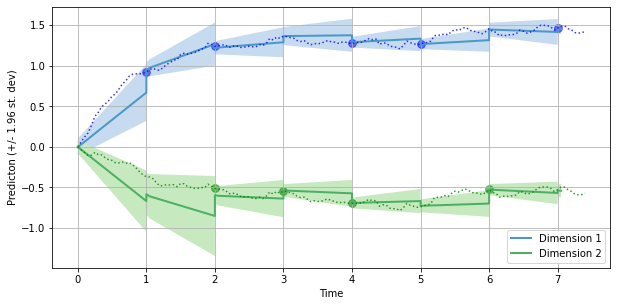

<Figure size 432x288 with 0 Axes>

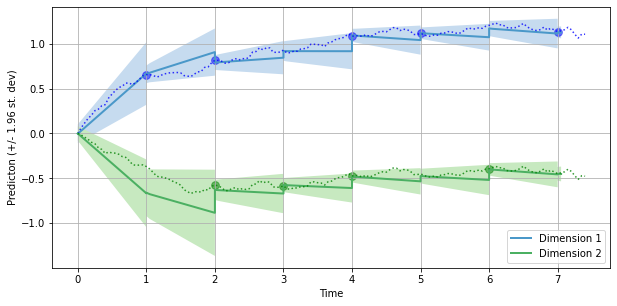

<Figure size 432x288 with 0 Axes>

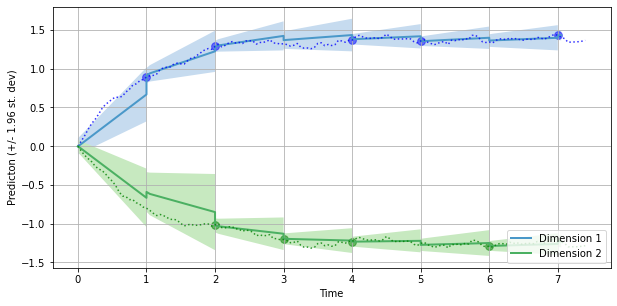

<Figure size 432x288 with 0 Axes>

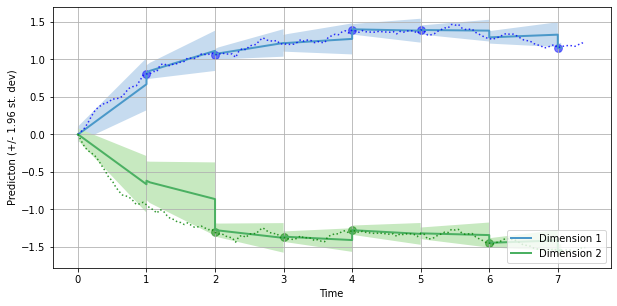

<Figure size 432x288 with 0 Axes>

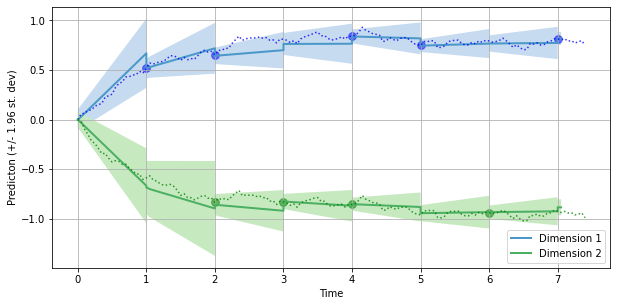

<Figure size 432x288 with 0 Axes>

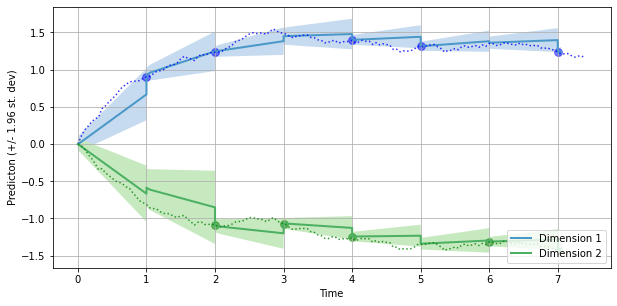

<Figure size 432x288 with 0 Axes>

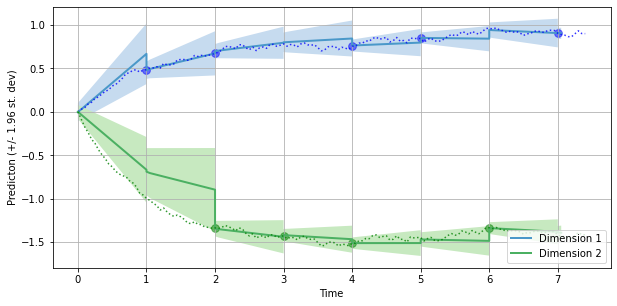

<Figure size 432x288 with 0 Axes>

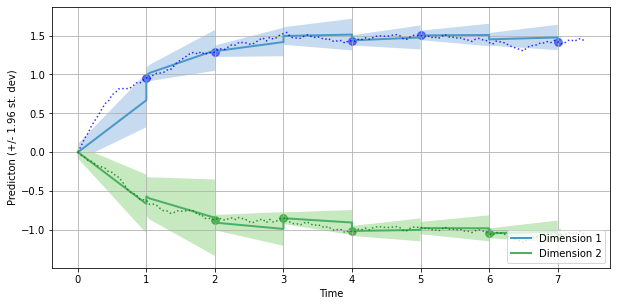

<Figure size 432x288 with 0 Axes>

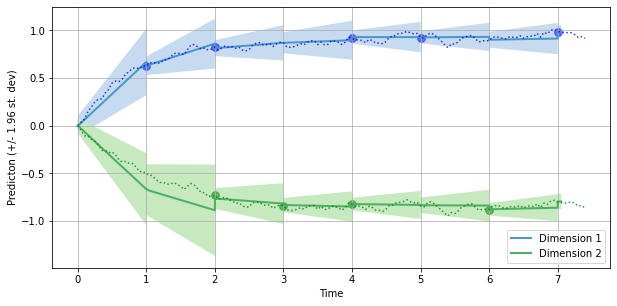

<Figure size 432x288 with 0 Axes>

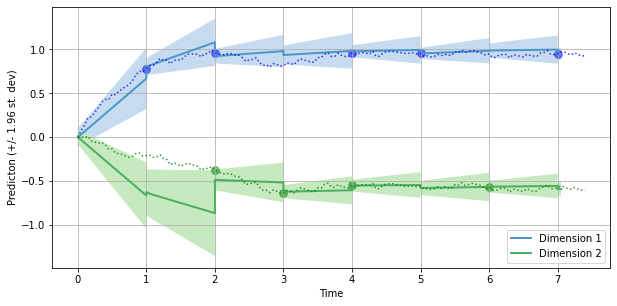

<Figure size 432x288 with 0 Axes>

In [24]:
from matplotlib import cm
#Plotting prediction against true trajectory

style = "fill"
params_dict={}
params_dict["input_size"]  = 2
params_dict["hidden_size"] = 50
params_dict["p_hidden"]    = 25
params_dict["prep_hidden"] = 25
params_dict["logvar"]      = True
params_dict["mixing"]      = 0.0001
params_dict["delta_t"]     = delta_t
params_dict["jitter"]      = 0
params_dict["gru_bayes"]   = "masked_mlp"
params_dict["solver"]      = "midpoint"

metadata    = double_OU_metadata

if type(params_dict) == np.ndarray:
        ## converting np array to dictionary:
        params_dict = params_dict.tolist()

model.eval()

    #Test data :
N           = 10
T           = double_OU_metadata["T"]
delta_t     = double_OU_metadata["delta_t"]
theta       = 1.0
sigma       = double_OU_metadata["sigma"]
rho         = double_OU_metadata["rho"]
r_mu        = [1.0,-1.0]
sample_rate = double_OU_metadata["sample_rate"]
dual_sample_rate = double_OU_metadata["dual_sample_rate"]
r_std       = np.sqrt(1/12)
T = 7.5
#generate (full) dataset)
df = OU_sample(T = T, dt = delta_t,
                    N = N, sigma = 0.1,
                    theta = theta,
                    r_mu = r_mu, r_std = r_std,
                    rho = rho, sample_rate = sample_rate,
                    dual_sample_rate = dual_sample_rate, max_lag =0, random_theta= random_theta,full=True,seed=432)

      ## for 10 time-points (our observations)
times_1 = [1.0, 2.0, 4.0, 5.0, 7.0,7.5]
times_2 = [2.0, 3.0, 4.0, 6.0]

times   = np.union1d(times_1,times_2)
obs     = df.loc[df["Time"].isin(times)].copy()
obs[["Mask_1","Mask_2"]]                   = 0
obs.loc[df["Time"].isin(times_1),"Mask_1"] = 1
obs.loc[df["Time"].isin(times_2),"Mask_2"] = 1

data = ODE_Dataset(panda_df=obs)
dl   = DataLoader(dataset=data, collate_fn=custom_collate_fn, shuffle=False, batch_size=1)

with torch.no_grad():
    for sample, b in enumerate(dl):
            times    = b["times"]
            time_ptr = b["time_ptr"]
            X        = b["X"]
            M        = b["M"]
            obs_idx  = b["obs_idx"]
            cov      = b["cov"]

            y = b["y"]
            hT, loss, _, t_vec, p_vec, _, eval_times, eval_vals = model(times, time_ptr, X.cuda(), M.cuda(), obs_idx.cuda(), delta_t=delta_t, T=T, cov = cov.cuda(), return_path=True)

            
            observations=X.detach().numpy()
            m, v = torch.chunk(p_vec[:,0,:],2,dim=1)

#upper bound of 95% confidence interval
            up   = m + torch.exp(0.5*v) * 1.96
#lower bound
            down = m - torch.exp(0.5*v) * 1.96

            plots_dict = dict()
            plots_dict["t_vec"] = t_vec
            plots_dict["up"] = up.cpu().detach().numpy()
            plots_dict["down"] = down.cpu().detach().numpy()
            plots_dict["m"] = m.cpu().detach().numpy()
            plots_dict["observations"] = observations
            plots_dict["mask"] = M.cpu().detach().numpy()

            fill_colors = [cm.Blues(0.25), cm.Greens(0.25)]

            line_colors = [cm.Blues(0.6), cm.Greens(0.6)]
            colors=["blue","green"]

            ## sde trajectory
            df_i = df.query(f"ID == {sample}")
#plot predicted trajectory with 95% confidence interval and true trajectory in dotted lines
            plt.figure(figsize=(10, 4.8))
            for dim in range(2):
                    plt.fill_between(x  = t_vec,
                                     y1 = down[:,dim].cpu().detach().numpy(),
                                     y2 = up[:,dim].cpu().detach().numpy(),
                                     facecolor = fill_colors[dim],
                                     alpha=1.0, zorder=1)
                    plt.plot(t_vec, m[:,dim].cpu().detach().numpy(), color=line_colors[dim], linewidth=2, zorder=2, label=f"Dimension {dim+1}")
                    observed_idx = np.where(plots_dict["mask"][:, dim]==1)[0]
                    plt.scatter(times[observed_idx], observations[observed_idx,dim], color=colors[dim], alpha=0.5, s=60)
                    plt.plot(df_i.Time, df_i[f"Value_{dim+1}"], ":", color=colors[dim], linewidth=1.5, alpha=0.8, label="_nolegend_")

            #plt.title("Test trajectory of a double OU process")
            plt.xlabel("Time")
            plt.grid()
            plt.legend(loc="lower right")
            plt.ylabel("Predicton (+/- 1.96 st. dev)")
            plt.show()
            #fname = f"{model_name}_sample{sample}_{style}.{format_image}"
            plt.tight_layout()
            #plt.savefig(fname)
            #print(f"Saved sample into '{fname}'.")
            #dict_name = f"paper-plots/{model_name}_sample{sample}_dict.npy"
            #np.save(dict_name, plots_dict)


